# Characterizing a Single-Species Graph
The purpose of this notebook is to characterize the dataset of genes, phenotypes, and annotations for Arabidopsis thaliana specifically. The sources of information include several different resources which are aggregated at differnet points in the analysis, and specified below. We want to figure out what kinds of properties the different graphs have in terms of potential predictive power for untangling pathway interactions or predicting pathway membership of regulatory network clusters. This is done for the purposes of figuring out if the predictions made over text descriptions that do *not* have the corresponding high-quality annotations or characterizations are likely to be useful to biologists.

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import sys
import gensim
import os
import warnings
import itertools
from collections import Counter
from inspect import signature
from scipy.stats import ks_2samp

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle, merge_list_dicts
from oats.utils.utils import function_wrapper, to_hms
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.datasets.string import get_string_protein_links_df
from oats.annotation.ontology import Ontology
from oats.annotation.annotation import write_annotations_to_tsv_file, read_annotations_from_tsv_file
from oats.graphs.pairwise import get_edgelist_with_doc2vec, get_edgelist_with_bagofwords, get_edgelist_with_setofwords
from oats.graphs.pairwise import get_edgelist_with_annotations, merge_edgelists, subset_edgelist_with_ids
from oats.objectives.functions import balance_classes

warnings.simplefilter('ignore')

## 1 Does the graph recapitulate known protein-protein interactions?
A more in depth description of this question here, what we expected and what we want to know and why we want to know it.

In [131]:
# This dataset is only focused on including all genes mapped to some text information.
dataset = Dataset()
dataset.add_data(pd.read_csv("../data/reshaped_files/ath_tair_gene_text.csv", lineterminator="\n"))
dataset.add_data(pd.read_csv("../data/reshaped_files/all_pppn_gene_textlong_annot.csv", lineterminator="\n"))
dataset.add_data(pd.read_csv("../data/reshaped_files/all_pppn_gene_textshort_annot.csv", lineterminator="\n"))
dataset.filter_by_species(["ath"])
dataset.collapse_by_first_gene_name()
dataset.filter_has_description()
dataset.filter_random_k(1000, seed=19824)
dataset.describe()


# ADDING NEW PIECE HERE
genes = dataset.get_gene_dictionary()
string_database_file = "/Users/irbraun/Downloads/3702.protein.links.detailed.v11.0.txt"
ppi_df = get_string_protein_links_df(string_database_file, genes)
genes_with_partners = set()
genes_with_partners.update(ppi_df["from"].values)
genes_with_partners.update(ppi_df["to"].values)
genes_with_partners = list(genes_with_partners)
dataset.filter_with_ids(ids=genes_with_partners)
dataset.describe()

Number of rows in the dataframe: 1000
Number of unique IDs:            1000
Number of unique descriptions:   721
Number of unique gene name sets: 1000
Number of species represented:   1
Number of rows in the dataframe: 393
Number of unique IDs:            393
Number of unique descriptions:   354
Number of unique gene name sets: 393
Number of species represented:   1


In [132]:
# Setup some of the preliminary ontology, embedding, and datset stuff.
doc2vec_model_filename = "../gensim/enwiki_dbow/doc2vec.bin"
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_filename)
ontology_filename = "../ontologies/mo.obo"
#ontology = Ontology(ontology_filename)
descriptions = dataset.get_description_dictionary()
#annotations = annotate_using_rabin_karp(descriptions, ontology)
genes = dataset.get_gene_dictionary()

# Construct the graphs based on similarity between the text associated with each gene.
name_to_df_mapping = {}
name_to_df_mapping["doc2vec"] = get_edgelist_with_doc2vec(doc2vec_model, descriptions)
#name_to_df_mapping["ontology"] = get_edgelist_with_annotations(annotations, ontology)
name_to_df_mapping["bagofwords"] = get_edgelist_with_bagofwords(descriptions) 
name_to_df_mapping["setofwords"] = get_edgelist_with_setofwords(descriptions)
df = merge_edgelists(name_to_df_mapping, default_value=0.000)
print(df.head(16))
print(df.shape)

    from  to   doc2vec  bagofwords  setofwords
0      0   0  0.000000    0.000000    0.000000
1      0   1  0.391817    0.915242    0.948276
2      0   2  0.569858    1.000000    1.000000
3      0   3  0.607987    0.803446    0.980000
4      0   4  0.350718    0.921216    0.977778
5      0   5  0.443974    0.781477    0.967391
6      0   6  0.450671    0.980426    0.980392
7      0   7  0.488673    0.803040    0.966667
8      0   8  0.412744    0.950371    0.970588
9      0   9  0.379198    0.848380    0.945946
10     0  10  0.389383    0.920819    1.000000
11     0  11  0.393709    0.874165    0.971429
12     0  12  0.503804    0.848380    1.000000
13     0  13  0.399292    0.983048    1.000000
14     0  14  0.451353    0.827625    0.965217
15     0  15  0.329067    0.713382    0.943820
(77421, 5)


In [133]:
# Merging information from the protein-protein interaction database (STRING) with this data.
string_database_file = "/Users/irbraun/Downloads/3702.protein.links.detailed.v11.0.txt"
ppi_df = get_string_protein_links_df(string_database_file, genes)
df = df.merge(right=ppi_df, how="left", on=["from","to"])
df.fillna(value=0,inplace=True)
print(df.head(10))

   from  to   doc2vec  bagofwords  setofwords  combined_score
0     0   0  0.000000    0.000000    0.000000             0.0
1     0   1  0.391817    0.915242    0.948276             0.0
2     0   2  0.569858    1.000000    1.000000             0.0
3     0   3  0.607987    0.803446    0.980000             0.0
4     0   4  0.350718    0.921216    0.977778             0.0
5     0   5  0.443974    0.781477    0.967391             0.0
6     0   6  0.450671    0.980426    0.980392             0.0
7     0   7  0.488673    0.803040    0.966667             0.0
8     0   8  0.412744    0.950371    0.970588             0.0
9     0   9  0.379198    0.848380    0.945946             0.0


### 1.1 Do the edges joining interacting proteins come from a different distribution?
Testing to see if the similarity values generated based on text were able to recapitulate the known protein-protein interactions from the STRING database specifically for Arabdidopsis proteins. Does a distinction need to be made here between whether or not nodes from the graph were not found at all in the STRING database, or whether it was just that
no relevant interaction (to another node in the dataset) occurs? Figure this out.

In [134]:
METHOD_NAMES = ["doc2vec", "bagofwords", "setofwords"]

In [137]:
# Use KS test to see if protein-protein interaction edges come from a unique distribution.
ppi_pos_dict = {name:(df[df["combined_score"] > 0.00][name].values) for name in METHOD_NAMES}
ppi_neg_dict = {name:(df[df["combined_score"] == 0.00][name].values) for name in METHOD_NAMES}
results = {}
for name in METHOD_NAMES:
    stat,p = ks_2samp(ppi_pos_dict[name],ppi_neg_dict[name])
    pos_mean = np.average(ppi_pos_dict[name])
    neg_mean = np.average(ppi_neg_dict[name])
    results[name] = {"pos_mean":pos_mean, "neg_mean":neg_mean, "D": stat, "p_value":p}  
    
print(pd.DataFrame(results).transpose())

            pos_mean  neg_mean         D       p_value
doc2vec     0.441514  0.445116  0.063819  1.976810e-11
bagofwords  0.820420  0.843573  0.063504  2.537737e-11
setofwords  0.970397  0.966637  0.044369  9.589055e-06


### 1.2 What do those distributions of edge weights in the graph look like?
The distributions of the samples are distinct enough for some of the similarity metrics that the KS tests are significant, where the mean distance between nodes connected by edges which correspond to real protein-protein interactions is lower than for those that do not. In the next cell the density plots of those distributions are visualized. The red distributions are edges that were not found to correspond to known protein-protein interactions, and the green distributions are for edges that do correspond to known protein-protein interactions.

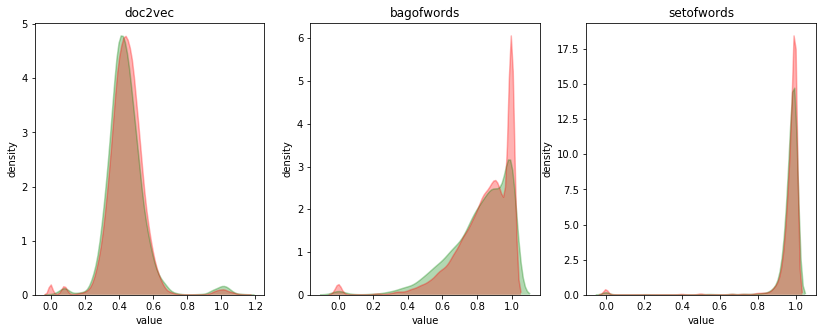

In [138]:
fig, axs = plt.subplots(1,len(METHOD_NAMES))
for col,ax in zip(METHOD_NAMES,axs):
    ax.set_title(col)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.kdeplot(ppi_pos_dict[col], color="green", shade=True, alpha=0.3, ax=ax)
    sns.kdeplot(ppi_neg_dict[col], color="red", shade=True, alpha=0.3, ax=ax) 
    
fig.set_size_inches(14.0, 5.0)
fig.show()

### 1.3 Can we practically use the graph to predict known protein-protein interactions?
This is a different question than above, because the false positive rate is a limiting factor in how practically useful it would be to generate predictions about real protein interactions. In the case of the statistical test above, the sample distribution could be significantly different than the whole distribution of edge values even if there are many high valued edges which look like they could come from the sample distribution (i.e., the sample distribution could be distinct because of a *lack* of low values, not there could still be many high values that aren't positive edges in this cases, which will be false positives).

In [139]:
# Class ratio of negative over positive, set arbitrary large to effectively do no balancing.
CLASS_RATIO = 3**10

In [140]:
# Providing summary statistics for precision recall curve using graph directly.
y_true_dict = {name:(np.where(df["combined_score"] > 0.000, 1, 0)) for name in METHOD_NAMES}
y_prob_dict = {name:(1 - df[name].values) for name in METHOD_NAMES}
results = {}
for name in METHOD_NAMES:
    y_true, y_prob = y_true_dict[name], y_prob_dict[name]
    y_true, y_prob = balance_classes(y_true, y_prob, CLASS_RATIO)
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    average_precision = average_precision_score(y_true, y_prob)
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    results[name] = {"auc":area, "baseline":baseline, "num_pos":n_pos, "num_neg":n_neg}
    
print(pd.DataFrame(results).transpose())

                 auc  baseline  num_pos  num_neg
doc2vec     0.045520   0.04194   3247.0  74174.0
bagofwords  0.051286   0.04194   3247.0  74174.0
setofwords  0.045944   0.04194   3247.0  74174.0


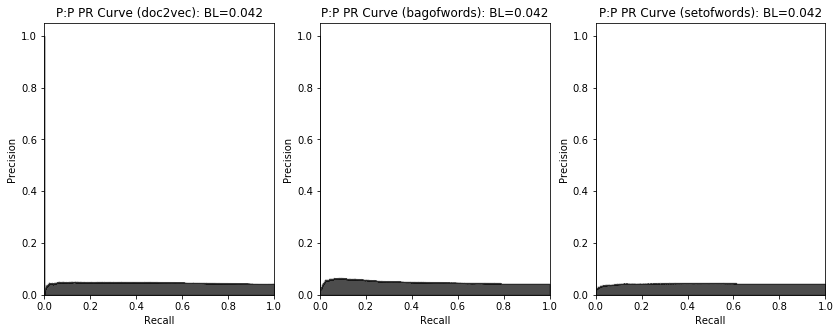

In [141]:
# Visualizing the precision recall curves for each method of estimating edge weight.
fig, axs = plt.subplots(1,len(METHOD_NAMES))
for method,ax in zip(METHOD_NAMES,axs):
    y_true, y_prob = y_true_dict[method], y_prob_dict[method]
    y_true, y_prob = balance_classes(y_true, y_prob, CLASS_RATIO)
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("P:P PR Curve ({0}): BL={1:0.3f}".format(method, baseline))
    
fig.set_size_inches(14.0, 5.0)
fig.show()

### 1.4 Is there evidence that querying the graph with one gene will return a successfully return a gene that it interacts with?
Explain what we mean by querying, and more in-depth description of what we're trying to find out here with these tests.

In [142]:
# Which genes have some known functional partner in the dataset?
genes_with_partners = set()
genes_with_partners.update(ppi_df["from"].values)
genes_with_partners.update(ppi_df["to"].values)

# Find the ranks of each of those partners when iteratively querying with each of gene.
partner_ranks = []
for gene_id in genes_with_partners:
    sub_df_one =  df[df["from"] == gene_id]
    sub_df_two = df[df["to"] == gene_id]
    sub_df_one["other"] = sub_df_one["to"]
    sub_df_two["other"] = sub_df_two["from"]
    merged_df = pd.concat([sub_df_one,sub_df_two],ignore_index=True)
    merged_df = merged_df.sort_values(by=["bagofwords"]).reset_index(drop=True)
    indices = merged_df.query("combined_score > 0.00").index.tolist()
    partner_ranks.extend(indices)







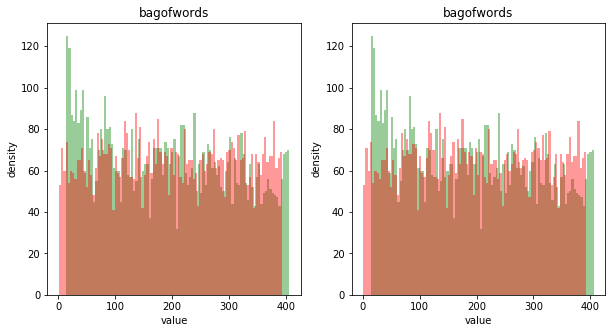

In [155]:
partner_ranks = [r+1 for r in partner_ranks]
max_rank = 393 #?
random_ranks = np.random.choice(np.arange(max_rank), len(partner_ranks))
random_ranks = [r+1 for r in random_ranks]

METHOD_NAMES = ["bagofwords", "bagofwords"]

fig, axs = plt.subplots(1,len(METHOD_NAMES))
for col,ax in zip(METHOD_NAMES,axs):
    ax.set_title(col)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.distplot(partner_ranks, bins=100, color="green", kde=False, ax=ax)
    sns.distplot(random_ranks, bins=100, color="red", kde=False, ax=ax) 

fig.set_size_inches(10.0, 5.0)
fig.show()